<img src="Transfer_Learning -1.png">

# 07. PyTorch Transfer Learning

Taking Parameters of what one model has learned on another dataset.

* Pretrained model = Foundation Models

In [1]:
import torch
import torchvision

torchvision.__version__ , torch.__version__



('0.15.0', '2.0.0')

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

## 1. Get Data

We need our food data to build a transfer learning model on.

In [4]:
import os
import zipfile
from pathlib import Path
import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exist, skipping redownload...")
else:
    print(f"Didn't find {image_path}, downloading it...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak and sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("DOwnloading data...")
        f.write(request.content)
    
    # Unzip pizza, steak,sushi data
    with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak and sushi data...")
        zip_ref.extractall(image_path)
        
    # REmove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exist, skipping redownload...


In [5]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and Dataloaders

Now we've got data, want to turn it into PyTorch DataLoaders, to do so we can use `data_setup.py` and the `create_dataloader.py` modules we created earlier.

Since we need transforms, so we have two ways:

1. Manually Created Transforms -  you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

**Important Point**: whenusing a pretrained model, it's importat that the data that you pass through is transformed in the same way that the data the model was trained on.

### 2.1 Creating a transform for `torchvision.model` (manual creation)

`torchvision.models` contains pretrained models right within torchvision

In [6]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    normalize
])

In [7]:
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                             test_dir=test_dir,
                                                                              transform=manual_transforms,
                                                                              batch_size=32) 
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x260214a9c10>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a tranform for `torchvision.models` (Auto Creation)

Automatic data transform creation based on the pretrained model weights you are using.

In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #Best available
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Create dataloaders using automatic transforms 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                              batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x260297e1d60>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model:
1. PyTorch domain libraries
2. `timm`
3. HuggingFace Hub
4. Paperswithcode

### 3.1 Which Pretrained model should you use?

*Experiment, experiment, experiment....*

The whole idea is to take already well-performing model from a problem similar to your own and then customize to your own problem.

Three things to consider:
1. Speed 
2. Size - No. of parameters
3. Performance - How well does it go on your chosen problem

Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on a server?

Looking at - https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights

Which model should we choose?

For our case , it looks like EffNetB0 is one of our best options in terms of performance vs size.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could

### 3.2 Setting up a pretrained model

Want to create an instance of pretrained EffNetB0

In [11]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #Best available

model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

<img src="Transfer_Learning -2.png">

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

<img src="Transfer_Learning -3.png">

<img src="Transfer_Learning -4.png">

<img src="Transfer_Learning -5.png">

### 3.3 Getting summary of our model with `torchinfo.summary()`

In [13]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
       input_size=(1, 3, 224, 224), # [batch, channel, height, width]
       col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer (head)

With a feature extractor model, typically you will freeze the base layers of a pretrained model and update the output layers to suit your own problems.

In [14]:
# Freeze all the base layers in EffNetB0
for param in model.features.parameters():
    param.requires_grad = False

In [15]:
# Update the classifier head of our model to suit our model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,    # 1280 is input feature of architecture
              out_features=len(class_names))    # Changing classes as per our problem
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [16]:
summary(model=model,
       input_size=(1, 3, 224, 224), # [batch, channel, height, width]
       col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [17]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)

In [18]:
# Import train function
from going_modular import engine

# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup trianing and save result
result = engine.train(model=model,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     epochs=10,
                     device=device)

# End the timer
end_time = timer()
print(f"[INFO] Total training time: {end_time- start_time} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8702 | train_acc: 0.7773 | test_loss: 0.7901 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7434 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5770 | train_acc: 0.8984 | test_loss: 0.5714 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5259 | train_acc: 0.9141 | test_loss: 0.5456 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5249 | train_acc: 0.8047 | test_loss: 0.5301 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.5667 | train_acc: 0.8125 | test_loss: 0.5081 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.4848 | train_acc: 0.8164 | test_loss: 0.4389 | test_acc: 0.9062
[INFO] Total training time: 37.8049655 seconds


In [19]:
result

{'train_loss': [1.0929144099354744,
  0.8702488243579865,
  0.7647661194205284,
  0.7114049196243286,
  0.6251776143908501,
  0.576964970678091,
  0.5259405188262463,
  0.5248874239623547,
  0.5666959509253502,
  0.48475512117147446],
 'train_acc': [0.40234375,
  0.77734375,
  0.80078125,
  0.7578125,
  0.79296875,
  0.8984375,
  0.9140625,
  0.8046875,
  0.8125,
  0.81640625],
 'test_loss': [0.9125327269236246,
  0.7900857528050741,
  0.7434170047442118,
  0.6344330509503683,
  0.6237866282463074,
  0.5714148680369059,
  0.5456167260805765,
  0.5300547182559967,
  0.5080666343371073,
  0.438949316740036],
 'test_acc': [0.5501893939393939,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8863636363636364,
  0.8759469696969697,
  0.8759469696969697,
  0.8768939393939394,
  0.8456439393939394,
  0.90625]}

## 5. Evaluate model by plotting loss curves

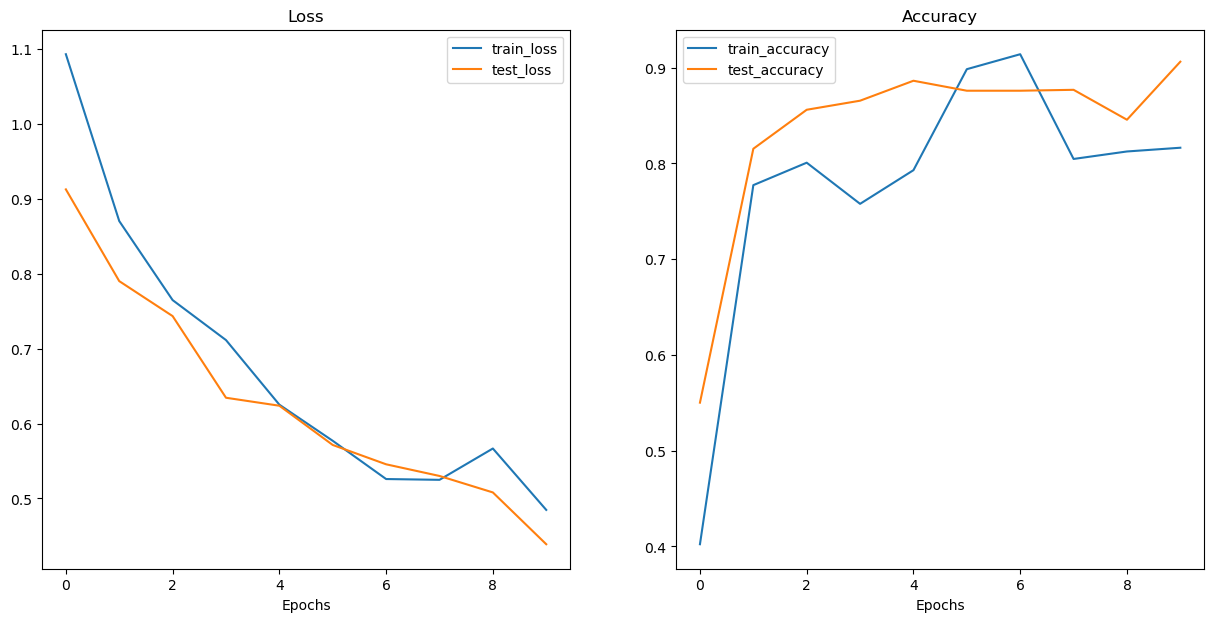

In [20]:
try:
    from helper_functions import plot_loss_curves
except:
    print(f"[INFO] couldn't find helper_functions.py, donwloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves
    
    
# Plot loss curve
plot_loss_curves(result)
        

## 6. Make predictions on images from the test set

Let's adhere to the data explorer's motto of *visualize, visualize...*

And make some qualitative predictions on our test set.

Keep in mind:

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device -  custom data/test data should be on same device
* Same transform - Transform in same way as train data.

To do all of this automatically, we will create a function called `pred_and_plot_image()`

1. Take in a trained model,  a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist.
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` to make sure it's ready for inference, this will turn of things like `nn.Dropout`
6. Tranform the target image and make sure its dimensionality is suited for the model
7. Make a prediction on the image by passing it to the model
8. Convert the model's output logits to perdiction probabilities using `torch.softmax()`
9. Convert pred probs to pred labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the pred label from step 9 and pred prob from step 8

In [52]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

# 1. Take in a trained model...
def pred_and_plot_image(model: nn.Module,
                       class_names: List[str],
                       image_path: str,
                       image_size: Tuple[int, int]=(224, 224),
                       transform: torchvision.transforms=None,
                       device: torch.device=device):

    # Open the image with PIL
    img = Image.open(image_path)
    
    # 3. Create a transform if one doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
    # Prediction on image #
    # 4. ake sure the model is on same device
    model.to(device)
    
    # 5. Turn on inference and eval mode
    model.eval()
    with torch.inference_mode():
        # 6. Tranform the image and add a extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim=0) # adds batch
        
        # 7. Make a prediction on transformed image by passing it to the model
        target_image_pred = model(transformed_image.to(device))
        
    # Convert models logit to pred probs
    target_image_pred_prob = torch.softmax(target_image_pred, dim=1)
    
    # 9. Conver mode pred prob to pred label
    target_image_pred_label = torch.argmax(target_image_pred_prob, dim=1)
    
    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_prob.max():.3f}")
    plt.axis("Off");

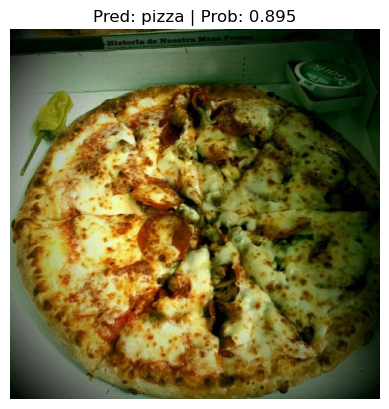

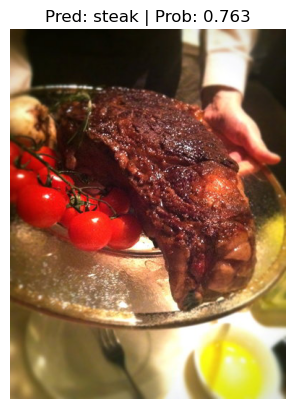

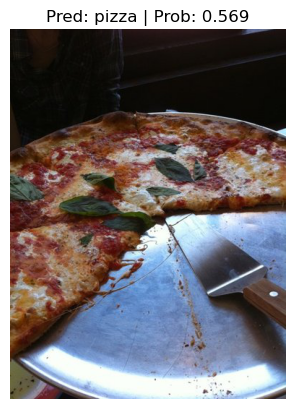

In [56]:
# Get a random list of image paths from the test set
import random

num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, 
                                       k=num_images_to_plot)


# Make predictions on and plot the image
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                       image_path=image_path,
                       class_names=class_names,
                       image_size=(224,224))

### 6.1 Making predicitons on a custom image

In [58]:
# Download the image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # Download image from GitHub
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Download {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exist, skipping download")

data\04-pizza-dad.jpeg already exist, skipping download


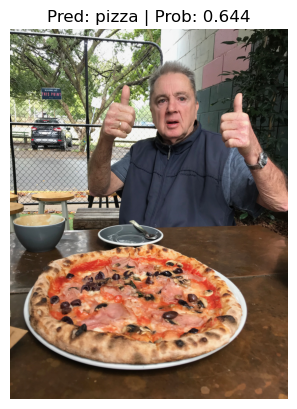

In [59]:
# Predict on custom image
pred_and_plot_image(model=model, 
                    class_names=class_names, 
                    image_path=custom_image_path)

In [3]:
%%writefile going_modular/predictions.py

import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from typing import List, Tuple
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Take in a trained model...
def pred_and_plot_image(model: nn.Module,
                       class_names: List[str],
                       image_path: str,
                       image_size: Tuple[int, int]=(224, 224),
                       transform: torchvision.transforms=None,
                       device: torch.device=device):

    # Open the image with PIL
    img = Image.open(image_path)
    
    # 3. Create a transform if one doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
    # Prediction on image #
    # 4. ake sure the model is on same device
    model.to(device)
    
    # 5. Turn on inference and eval mode
    model.eval()
    with torch.inference_mode():
        # 6. Tranform the image and add a extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim=0) # adds batch
        
        # 7. Make a prediction on transformed image by passing it to the model
        target_image_pred = model(transformed_image.to(device))
        
    # Convert models logit to pred probs
    target_image_pred_prob = torch.softmax(target_image_pred, dim=1)
    
    # 9. Conver mode pred prob to pred label
    target_image_pred_label = torch.argmax(target_image_pred_prob, dim=1)
    
    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_prob.max():.3f}")
    plt.axis("Off");

Overwriting going_modular/predictions.py
